### Risk score calculation

The final assessment on the re-
silience of the air traffic network against potential sudden
disruptive events like natural catastrophes or epidemics at
different spatial scales will be based on the so-called **risk score**
calculation for each country or world region. The comparison
of countries will be based on the risk score (RS), which is
defined as follows:

$$
RS = \frac{(1 - ORPC_N) + (1 - A_N) + VR}{3} \cdot 100,
$$
where:
- \( ORPC_N \) represents the Outgoing Routes Per Capita normalized,
- \( A_N \) represents the Airports per country normalized,
- \( VR \) represents the Visa Restriction score.

The domains for each variable are given by:
- \( RS \in (0, 100] \),
- \( ORPC_N \in (0, 1] \),
- \( A_N \in (0, 1] \),
- \( VR \in (0, 1] \).

In [129]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#### Reading in the data

In [130]:
airports = pd.read_csv('EXPORTED_DATA/nodes.csv').rename(columns={'Unnamed: 0':'id'})
routes = pd.read_csv('EXPORTED_DATA/edges.csv')
geo_df = gpd.read_file('EXPORTED_DATA/UN_geodata.geojson')

#### Data preprocessing

All of the further calculations rely on a rather major simplification that we only look at routes where source country is not the destination country as well, meaning that we only consider routes that take passengers away from a certain country/region.

Adding source and destination country ISO codes to routes to filter out within-country flights.

In [131]:
#Adding source ISO code
routes = routes.merge(airports[['id', 'iso']], left_on='source', right_on='id', how='left')
routes.rename(columns={'iso': 'source_iso'}, inplace=True)
routes.drop('id', axis=1, inplace=True) 

#Adding destination ISO code
routes = routes.merge(airports[['id', 'iso']], left_on='destination', right_on='id', how='left')
routes.rename(columns={'iso': 'destination_iso'}, inplace=True)
routes.drop('id', axis=1, inplace=True)  # Clean up extra column

In [132]:
routes.shape

(36816, 12)

In [133]:
#Keeping only the international routes
routes_int = routes[routes['source_iso'] != routes['destination_iso']]
routes_int.shape

(19685, 12)

Now also only keep the airports that can be found among the source airports in the filtered routes dataset.

In [134]:
airports.shape

(3147, 9)

In [135]:
airports_int = airports[airports['id'].isin(routes_int['source'])]
airports_int.shape

(1213, 9)

### Countries

### Outgoing Routes Per Capita normalized

Following metric is calculated using the 2014 population value. 

**NB!** Currently the airplane capacity is not taken into account!

In [136]:
geo_df['outgoing_routes'] = None
geo_df['or_per_capita_2014'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'outgoing_routes'] = len(routes_int[routes_int['source_iso'] == country])
    geo_df.loc[geo_df['Country Code'] == country, 'or_per_capita_2014'] = len(routes_int[routes_int['source_iso'] == country]) /  geo_df.loc[geo_df['Country Code'] == country, '2014']

In [137]:
from sklearn.preprocessing import QuantileTransformer

#Using a quantile transformer to avoid strongly skewed results (even after scaling)
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=100)

geo_df['orpc2014_n'] = scaler.fit_transform(geo_df[['or_per_capita_2014']]).flatten()
#geo_df['orpc2014_n'] = (geo_df['or_per_capita_2014'] - geo_df['or_per_capita_2014'].min()) / (geo_df['or_per_capita_2014'].max() - geo_df['or_per_capita_2014'].min())
geo_df['orpc2014_n'] = pd.to_numeric(geo_df['orpc2014_n'], errors='coerce')

Visualising the results.

In [138]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [139]:
geo_df.dtypes

Country Name            object
Country Code            object
2014                   float64
2022                   float64
Region                  object
IncomeGroup             object
OF Country Name         object
geometry              geometry
outgoing_routes         object
or_per_capita_2014      object
orpc2014_n             float64
dtype: object

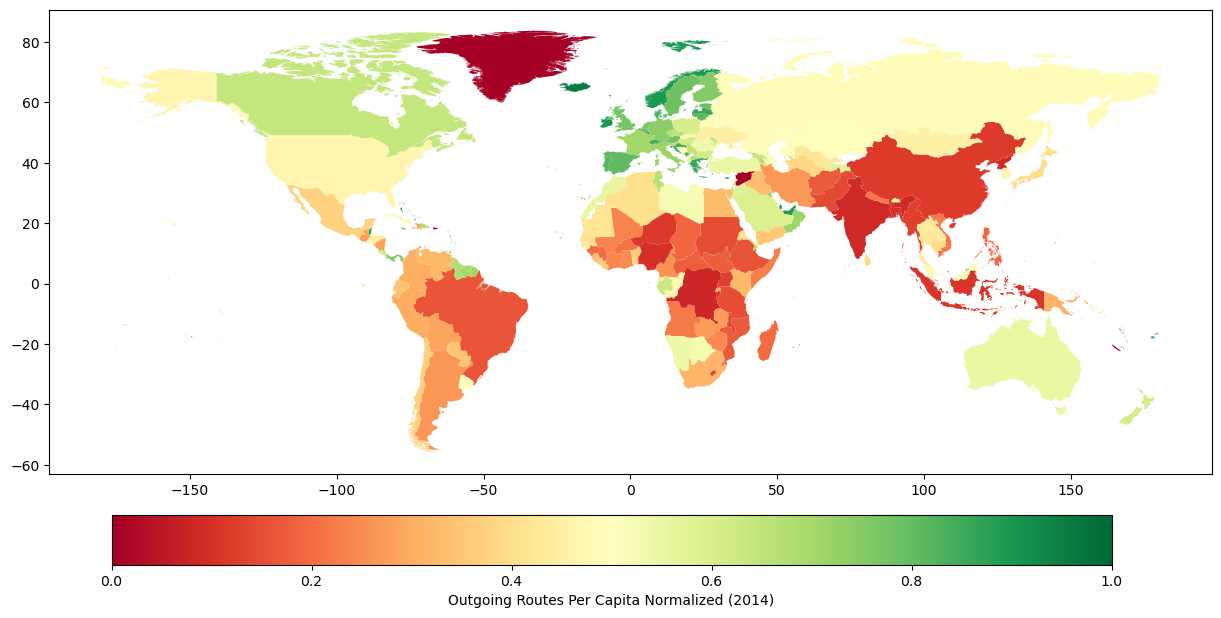

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cbar = geo_df.plot(column='orpc2014_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Outgoing Routes Per Capita Normalized (2014)",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [141]:
geo_df[geo_df['outgoing_routes'] == geo_df['outgoing_routes'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n
65,United Kingdom,GBR,64602298.0,66971395.0,Europe & Central Asia,High income,United Kingdom,"MULTIPOLYGON (((-6.28751 49.91401, -6.29727 49...",1305,0.00002,0.776452


In [142]:
geo_df[geo_df['orpc2014_n'] == geo_df['orpc2014_n'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n
147,Palau,PLW,17796.0,18055.0,East Asia & Pacific,Upper middle income,Palau,"MULTIPOLYGON (((131.81300 2.96044, 131.79518 2...",6,0.000337,1.0


### Airports per country normalized

In [143]:
invalid_geometries = geo_df[~geo_df.geometry.is_valid]

#Turns out that some of the polygons are invalid and need to be fixed in order to calculate the area properly
geo_df['geometry'] = geo_df.geometry.apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

In [144]:
print("Invalid geometries found after fixing:", geo_df[~geo_df.geometry.is_valid]) #None

Invalid geometries found after fixing: Empty GeoDataFrame
Columns: [Country Name, Country Code, 2014, 2022, Region, IncomeGroup, OF Country Name, geometry, outgoing_routes, or_per_capita_2014, orpc2014_n]
Index: []


In [145]:
#Find the areas of the countries

#Convert to an equal-area CRS
geo_df = geo_df.to_crs(epsg=6933) #Cylindrical Equal Area
#Area to square kilometers
geo_df['area_sqkm'] = geo_df.area / 1e6

geo_df = geo_df.to_crs(epsg=4326)

In [146]:
geo_df['airports'] = None
geo_df['airports_per_sqkm'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'airports'] = len(airports_int[airports_int['iso'] == country])
    geo_df.loc[geo_df['Country Code'] == country, 'airports_per_sqkm'] = len(airports_int[airports_int['iso'] == country]) /  geo_df.loc[geo_df['Country Code'] == country, 'area_sqkm']

In [147]:
from sklearn.preprocessing import QuantileTransformer

#Using a quantile transformer to avoid strongly skewed results (even after scaling)
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=100)

geo_df['apsqkm_n'] = scaler.fit_transform(geo_df[['airports_per_sqkm']]).flatten()
geo_df['apsqkm_n'] = pd.to_numeric(geo_df['apsqkm_n'], errors='coerce')

In [148]:
geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

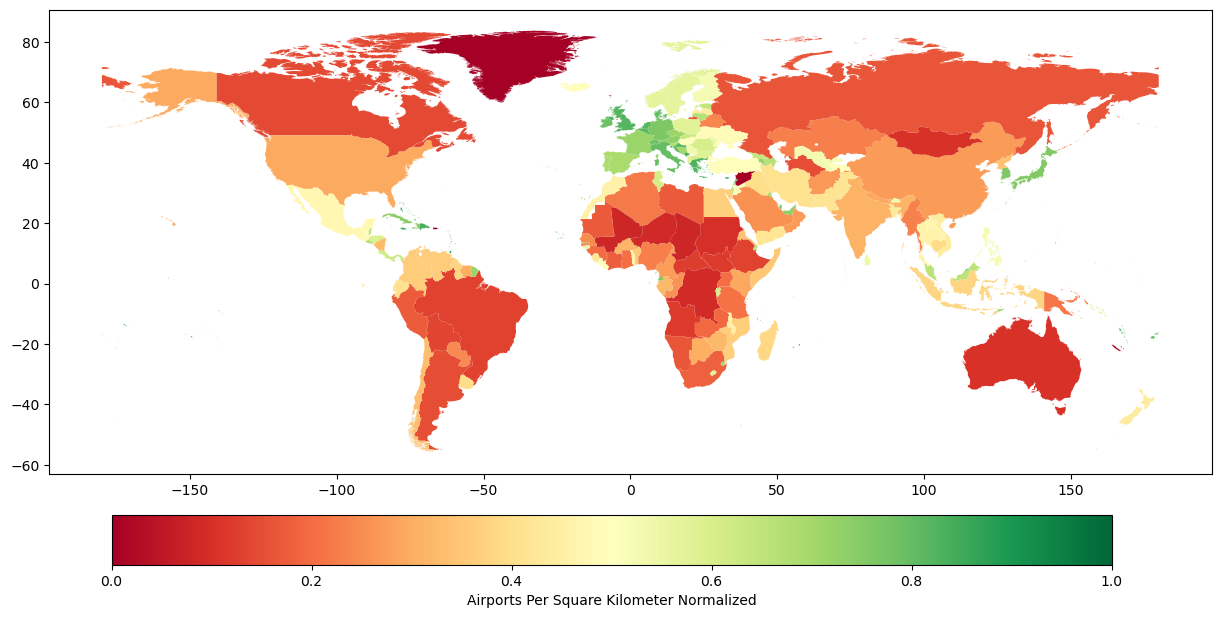

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='apsqkm_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Airports Per Square Kilometer Normalized",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [150]:
geo_df[geo_df['airports'] == geo_df['airports'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n
193,United States,USA,318386329.0,333287557.0,North America,High income,United States,"MULTIPOLYGON (((179.67140 51.87718, 179.64210 ...",1078,0.000003,0.465497,9.464444e+06,65,0.000007,0.294954


In [151]:
geo_df[geo_df['apsqkm_n'] == geo_df['apsqkm_n'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n
188,Tuvalu,TUV,10899.0,11312.0,East Asia & Pacific,Upper middle income,Tuvalu,"MULTIPOLYGON (((179.90610 -9.41863, 179.90528 ...",1,0.000092,0.946652,23.018376,1,0.043444,1.0


### Visa Restriction

In [153]:
geo_df['avg_visa_restriction'] = None

for country in geo_df['Country Code']:
    geo_df.loc[geo_df['Country Code'] == country, 'avg_visa_restriction'] = np.sum(routes_int.loc[routes_int['source_iso'] == country, 'visa']) / len(routes_int[routes_int['source_iso'] == country])

geo_df['avg_visa_restriction'] = pd.to_numeric(geo_df['avg_visa_restriction'], errors='coerce')

/var/folders/5q/01tqbn6d2bn07z8n_c06sz400000gn/T/ipykernel_49062/184139807.py:4: RuntimeWarning: invalid value encountered in scalar divide
  geo_df.loc[geo_df['Country Code'] == country, 'avg_visa_restriction'] = np.sum(routes_int.loc[routes_int['source_iso'] == country, 'visa']) / len(routes_int[routes_int['source_iso'] == country])


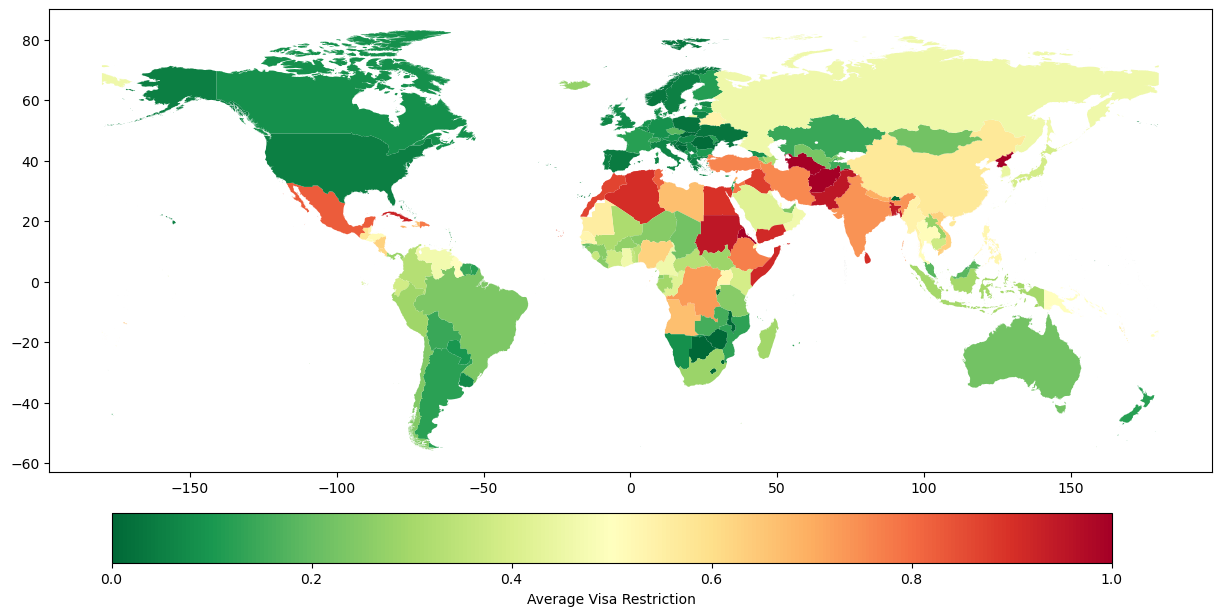

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='avg_visa_restriction', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Average Visa Restriction",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

In [155]:
geo_df[geo_df['avg_visa_restriction'] == geo_df['avg_visa_restriction'].max()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
1,Afghanistan,AFG,32716210.0,41128771.0,South Asia,Low income,Afghanistan,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38...",20,0.000001,0.170567,642181.141487,4,0.000006,0.267597,1.0
55,Eritrea,ERI,3323425.0,3684032.0,Sub-Saharan Africa,Low income,Eritrea,"MULTIPOLYGON (((40.02622 15.88264, 40.06267 15...",7,0.000002,0.400143,122537.888963,1,0.000008,0.336788,1.0
151,"Korea, Dem. People's Rep.",PRK,25126131.0,26069416.0,East Asia & Pacific,Low income,North Korea,"MULTIPOLYGON (((125.31275 37.74140, 125.29575 ...",4,0.0,0.082231,122379.346211,1,0.000008,0.339198,1.0
182,Turkmenistan,TKM,5663152.0,6430770.0,Europe & Central Asia,Upper middle income,Turkmenistan,"MULTIPOLYGON (((53.10206 38.75507, 53.09474 38...",11,0.000002,0.384348,470849.123915,1,0.000002,0.149805,1.0


In [156]:
geo_df[geo_df['avg_visa_restriction'] == geo_df['avg_visa_restriction'].min()]

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry,outgoing_routes,or_per_capita_2014,orpc2014_n,area_sqkm,airports,airports_per_sqkm,apsqkm_n,avg_visa_restriction
12,Burundi,BDI,10494913.0,12889576.0,Sub-Saharan Africa,Low income,Burundi,"MULTIPOLYGON (((30.41507 -2.31309, 30.41848 -2...",3,0.0,0.101621,27041.228345,1,0.000037,0.596647,0.0
20,Bosnia and Herzegovina,BIH,3571068.0,3233526.0,Europe & Central Asia,Upper middle income,Bosnia and Herzegovina,"MULTIPOLYGON (((16.94153 45.24122, 16.94732 45...",15,0.000004,0.495020,51826.708347,3,0.000058,0.699313,0.0
28,Bhutan,BTN,736357.0,782455.0,South Asia,Lower middle income,Bhutan,"MULTIPOLYGON (((90.26180 28.33535, 90.26180 28...",5,0.000007,0.587380,40365.396408,1,0.000025,0.532914,0.0
29,Botswana,BWA,2260376.0,2630296.0,Sub-Saharan Africa,Upper middle income,Botswana,"MULTIPOLYGON (((25.25978 -17.79411, 25.21937 -...",11,0.000005,0.524946,579029.287274,4,0.000007,0.303106,0.0
49,Dominica,DMA,69371.0,72737.0,Latin America & Caribbean,Upper middle income,Dominica,"MULTIPOLYGON (((-61.36286 15.20181, -61.37409 ...",8,0.000115,0.970171,730.311955,1,0.001369,0.906493,0.0
63,"Micronesia, Fed. Sts.",FSM,109024.0,114164.0,East Asia & Pacific,Lower middle income,Micronesia,"MULTIPOLYGON (((154.81764 0.92219, 154.81284 0...",5,0.000046,0.894157,633.848575,4,0.006311,0.970646,0.0
109,Lesotho,LSO,2095242.0,2305825.0,Sub-Saharan Africa,Lower middle income,Lesotho,"MULTIPOLYGON (((28.98085 -28.90904, 28.99542 -...",1,0.0,0.132936,30106.435505,1,0.000033,0.563294,0.0
111,Luxembourg,LUX,556319.0,653103.0,Europe & Central Asia,High income,Luxembourg,"MULTIPOLYGON (((6.03863 50.14841, 6.06137 50.1...",54,0.000097,0.954504,2608.476217,1,0.000383,0.862679,0.0
119,Marshall Islands,MHL,50419.0,41569.0,East Asia & Pacific,Upper middle income,Marshall Islands,"MULTIPOLYGON (((168.71681 4.57477, 168.68539 4...",5,0.000099,0.959932,164.814334,2,0.012135,0.980156,0.0
130,Malawi,MWI,16477966.0,20405317.0,Sub-Saharan Africa,Low income,Malawi,"MULTIPOLYGON (((34.71161 -12.12081, 34.68897 -...",8,0.0,0.141426,119397.803386,2,0.000017,0.453802,0.0


### Risk score

In [157]:
geo_df['risk_score'] = (((1 - geo_df['orpc2014_n']) + (1 - geo_df['apsqkm_n']) + geo_df['avg_visa_restriction']) / 3) * 100

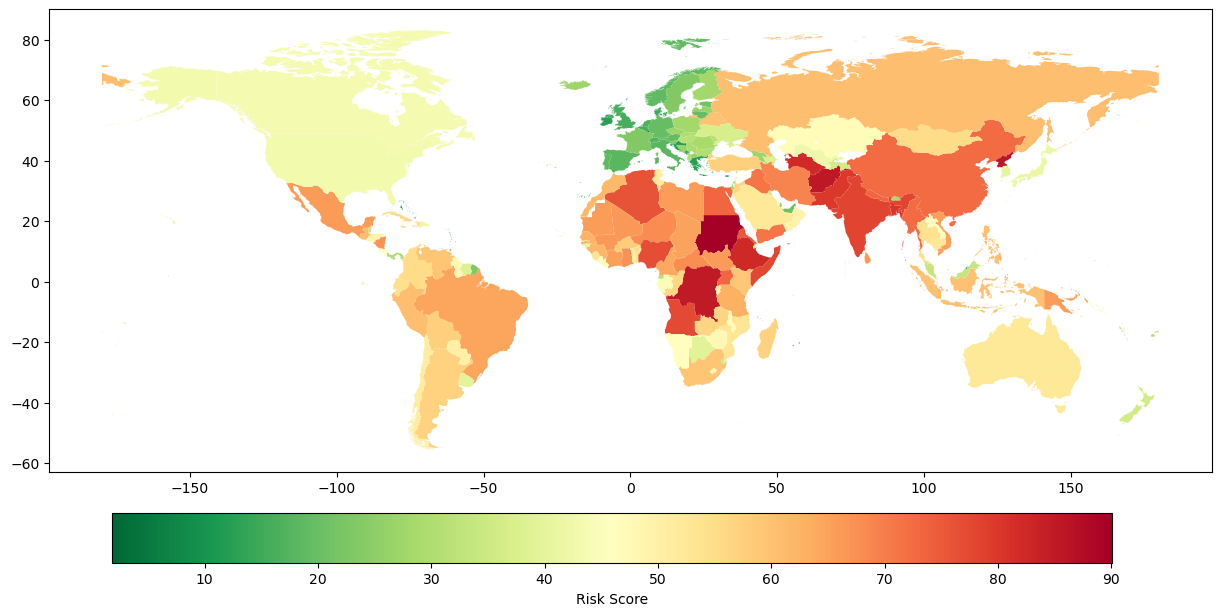

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df.plot(column='risk_score', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Risk Score",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

Classifying the countries to three risk classes - low, medium and high.

In [159]:
bins = [0, 30, 60, 100]
labels = ['low', 'medium', 'high']

geo_df['risk_class'] = pd.cut(geo_df['risk_score'], bins=bins, labels=labels, right=False)

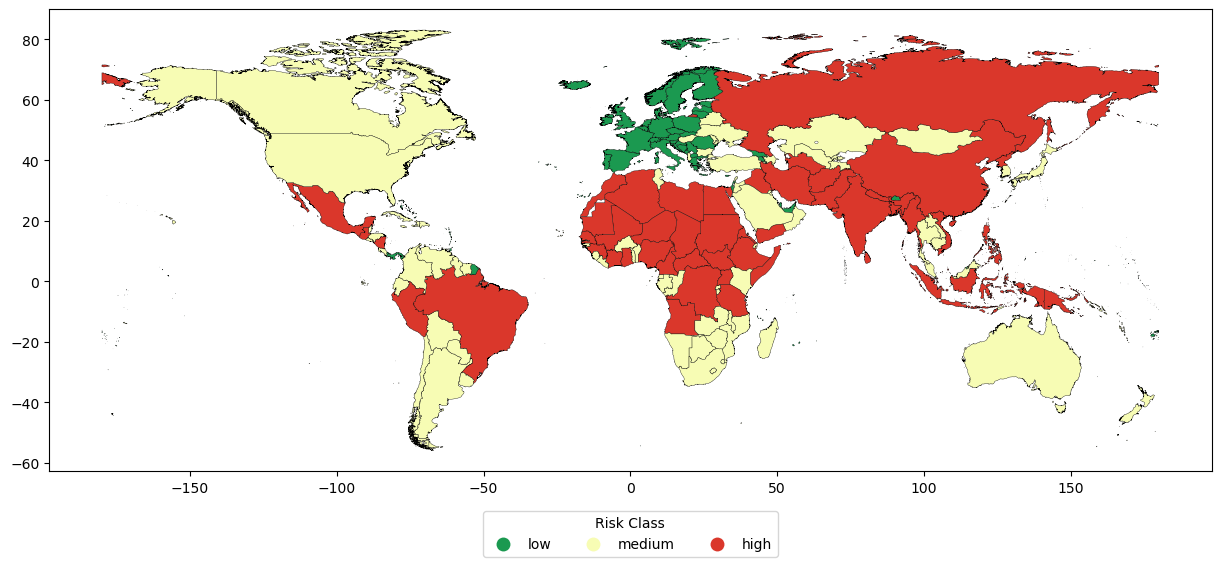

In [160]:
from matplotlib.colors import ListedColormap

color_dict = {
    'Low': '#1b9950',
    'Medium': '#f7fcb4',
    'High': '#da372b'
}

cmap = ListedColormap([color_dict[x] for x in color_dict.keys()])

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot = geo_df.plot(column='risk_class', ax=ax, cmap=cmap, legend=True,
                   legend_kwds={'title': "Risk Class", 'loc': 'lower center',
                                'bbox_to_anchor': (0.5, -0.2), 'ncol': len(color_dict)},
            edgecolor='black', linewidth=0.25)

plt.show()

### Regions

In [161]:
geo_df['Region'].unique()

array(['Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa',
       'Europe & Central Asia', 'Middle East & North Africa',
       'East Asia & Pacific', 'North America'], dtype=object)

For each **region** label listed in the geodataframe - 'Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia', 'Middle East & North Africa','East Asia & Pacific', 'North America' - I will create a new multipolygon based on the countries located within this region. Then a similar risk score calulation schema will be carried out as done previously, with regions being the new "countries".

In [162]:
#Adding the region label to airports

airports_int = airports_int.merge(geo_df[['Country Code', 'Region']], left_on = 'iso', right_on = 'Country Code').drop(columns='Country Code')

In [163]:
#Adding region labels to routes as well to keep only the interregional routes

#Source region
routes_int = routes_int.merge(geo_df[['Country Code', 'Region']], left_on = 'source_iso', right_on = 'Country Code').drop(columns='Country Code').rename(columns={'Region':'source_reg'})

#Destination region
routes_int = routes_int.merge(geo_df[['Country Code', 'Region']], left_on = 'destination_iso', right_on = 'Country Code').drop(columns='Country Code').rename(columns={'Region':'destination_reg'})

In [164]:
#Filtering out only the interregional flights and airports
routes_reg = routes_int[routes_int['source_reg'] != routes_int['destination_reg']]
airports_reg = airports_int[airports_int['id'].isin(routes_reg['source'])]

In [165]:
print(f"International airports: {len(airports_int)}")
print(f"Interregional airports: {len(airports_reg)}")

International airports: 1100
Interregional airports: 575


In [166]:
print(f"International routes: {len(routes_int)}")
print(f"Interregional routes: {len(routes_reg)}")

International routes: 18347
Interregional routes: 5780


In [167]:
#Creating a new geodataframe for region

from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

#Ensure valid geometries
geo_df['geometry'] = geo_df['geometry'].apply(lambda geom: geom if geom.is_valid else geom.buffer(0))

def aggregate_geometries(group):
    return pd.Series({
        'geometry': unary_union(group.geometry),
        'pop_2014': group['2014'].sum(),
        'pop_2022': group['2022'].sum()
    })

region_geom = geo_df.groupby('Region').apply(aggregate_geometries).reset_index()
geo_df_reg = gpd.GeoDataFrame(region_geom, geometry = 'geometry', crs = "EPSG:4326")

In [168]:
#Adding area column

geo_df_reg = geo_df_reg.to_crs(epsg=6933) #Cylindrical Equal Area
geo_df_reg['area_sqkm'] = geo_df_reg.area / 1e6
geo_df_reg = geo_df_reg.to_crs(epsg=4326)

In [169]:
geo_df_reg

,Region,geometry,pop_2014,pop_2022,area_sqkm
0,East Asia & Pacific,"MULTIPOLYGON (((169.26157 -52.55454, 169.24500...",2.254840e+09,2.351976e+09,2.448524e+07
1,Europe & Central Asia,"MULTIPOLYGON (((3.47779 -54.39674, 3.48666 -54...",8.946835e+08,9.112753e+08,2.986688e+07
2,Latin America & Caribbean,"MULTIPOLYGON (((-67.47559 -55.82906, -67.47201...",6.147100e+08,6.589805e+08,2.031003e+07
3,Middle East & North Africa,"MULTIPOLYGON (((52.37469 12.20059, 52.38950 12...",4.274912e+08,4.882359e+08,1.085711e+07
4,North America,"MULTIPOLYGON (((-155.08714 19.86038, -155.0864...",3.538889e+08,3.722810e+08,1.941018e+07
5,South Asia,"MULTIPOLYGON (((73.16310 -0.68182, 73.17254 -0...",1.754030e+09,1.919348e+09,5.057373e+06
6,Sub-Saharan Africa,"MULTIPOLYGON (((37.61883 -46.95436, 37.60206 -...",9.815066e+08,1.211190e+09,2.393132e+07


### Outgoing Routes Per Capita normalized

Currently using population from 2014.

In [170]:
geo_df_reg['outgoing_routes'] = None
geo_df_reg['or_per_capita_2014'] = None

for region in geo_df_reg['Region']:
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'outgoing_routes'] = len(routes_reg[routes_reg['source_reg'] == region])
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'or_per_capita_2014'] = len(routes_reg[routes_reg['source_reg'] == region]) /  geo_df_reg.loc[geo_df_reg['Region'] == region, 'pop_2014']

In [171]:
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=3)

geo_df_reg['orpc2014_n'] = scaler.fit_transform(geo_df_reg[['or_per_capita_2014']]).flatten()
geo_df_reg['orpc2014_n'] = pd.to_numeric(geo_df_reg['orpc2014_n'], errors='coerce')

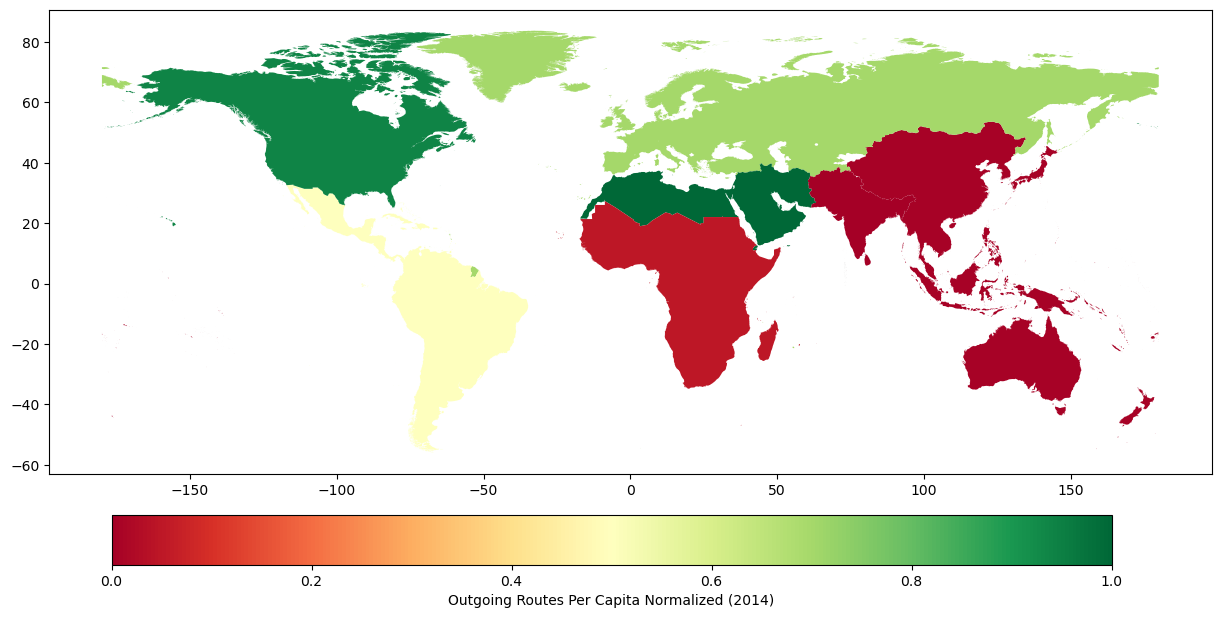

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cbar = geo_df_reg.plot(column='orpc2014_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Outgoing Routes Per Capita Normalized (2014)",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

### Airports per region normalized

In [108]:
airports_reg

,id,name,city,country,iso,iata,icao,lat,lon,Region
2,16,Keflavik International Airport,Keflavik,Iceland,ISL,KEF,BIKF,63.985001,-22.605600,Europe & Central Asia
4,8209,Vinnytsia/Gavyryshivka Airport,Vinnitsa,Ukraine,UKR,VIN,UKWW,49.242531,28.613778,Europe & Central Asia
5,2939,Boryspil International Airport,Kiev,Ukraine,UKR,KBP,UKBB,50.345001,30.894699,Europe & Central Asia
6,2940,Donetsk International Airport,Donetsk,Ukraine,UKR,DOK,UKCC,48.073601,37.739700,Europe & Central Asia
7,2941,Dnipropetrovsk International Airport,Dnepropetrovsk,Ukraine,UKR,DNK,UKDD,48.357201,35.100601,Europe & Central Asia
...,...,...,...,...,...,...,...,...,...,...
1093,4105,Hosea Kutako International Airport,Windhoek,Namibia,NAM,WDH,FYWH,-22.479900,17.470900,Sub-Saharan Africa
1095,4119,Djibouti-Ambouli Airport,Djibouti,Djibouti,DJI,JIB,HDAM,11.547300,43.159500,Middle East & North Africa
1096,4162,Conakry International Airport,Conakry,Guinea,GIN,CKY,GUCY,9.576890,-13.612000,Sub-Saharan Africa
1097,4304,Cheddi Jagan International Airport,Georgetown,Guyana,GUY,GEO,SYCJ,6.498550,-58.254101,Latin America & Caribbean


In [173]:
geo_df_reg['airports'] = None
geo_df_reg['airports_per_sqkm'] = None

for region in geo_df_reg['Region']:
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'airports'] = len(airports_reg[airports_reg['Region'] == region])
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'airports_per_sqkm'] = len(airports_reg[airports_reg['Region'] == region]) /  geo_df_reg.loc[geo_df_reg['Region'] == region, 'area_sqkm']

In [175]:
scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=3)

geo_df_reg['apsqkm_n'] = scaler.fit_transform(geo_df_reg[['airports_per_sqkm']]).flatten()
geo_df_reg['apsqkm_n'] = pd.to_numeric(geo_df_reg['apsqkm_n'], errors='coerce')

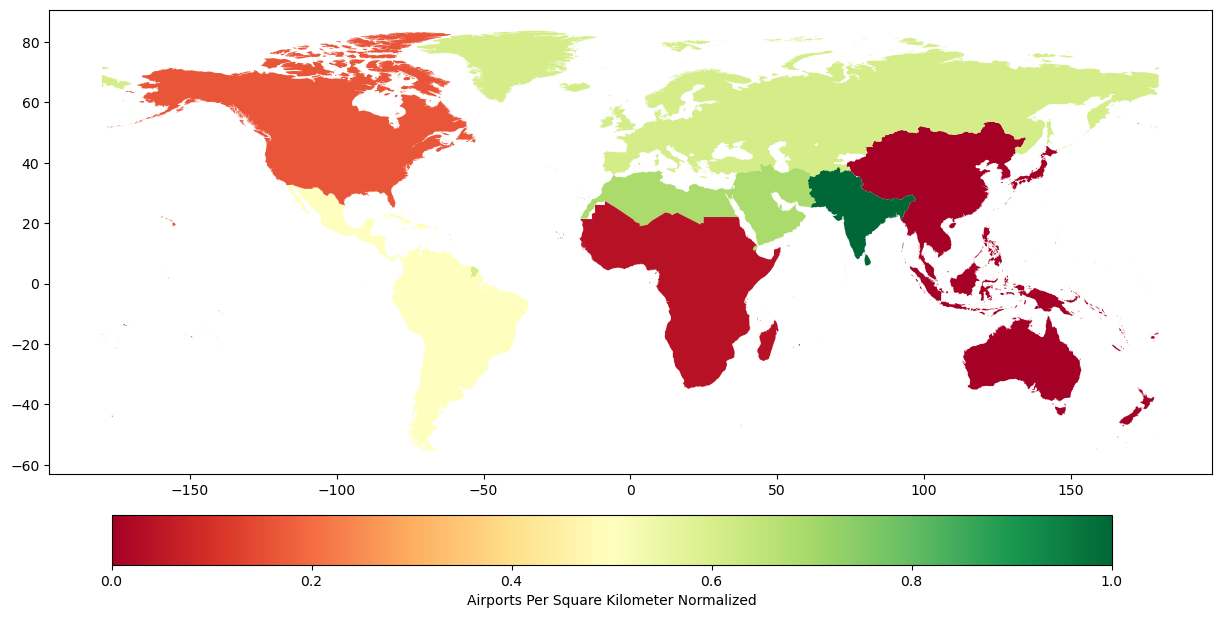

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df_reg.plot(column='apsqkm_n', ax=ax, cmap='RdYlGn', legend=True,
            legend_kwds={'label': "Airports Per Square Kilometer Normalized",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

### Visa restriction

In [178]:
geo_df_reg['avg_visa_restriction'] = None

for region in geo_df_reg['Region']:
    geo_df_reg.loc[geo_df_reg['Region'] == region, 'avg_visa_restriction'] = np.sum(routes_reg.loc[routes_reg['source_reg'] == region, 'visa']) / len(routes_reg[routes_reg['source_reg'] == region])

geo_df_reg['avg_visa_restriction'] = pd.to_numeric(geo_df_reg['avg_visa_restriction'], errors='coerce')

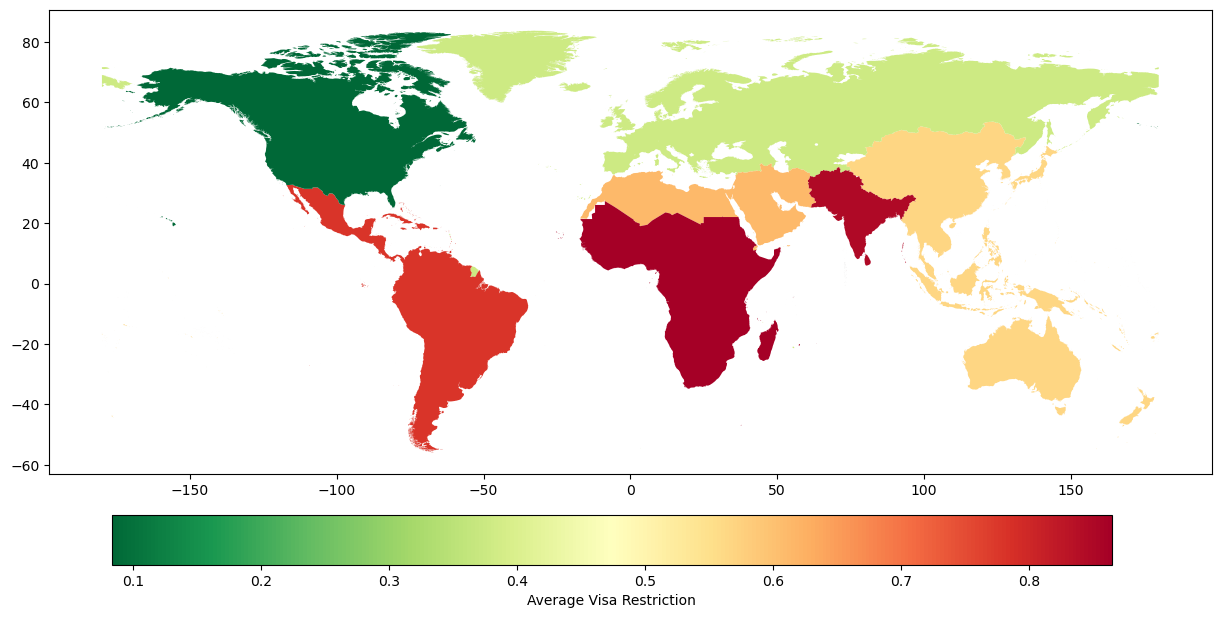

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df_reg.plot(column='avg_visa_restriction', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Average Visa Restriction",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()

### Risk score

In [180]:
geo_df_reg['risk_score'] = (((1 - geo_df_reg['orpc2014_n']) + (1 - geo_df_reg['apsqkm_n']) + geo_df_reg['avg_visa_restriction']) / 3) * 100

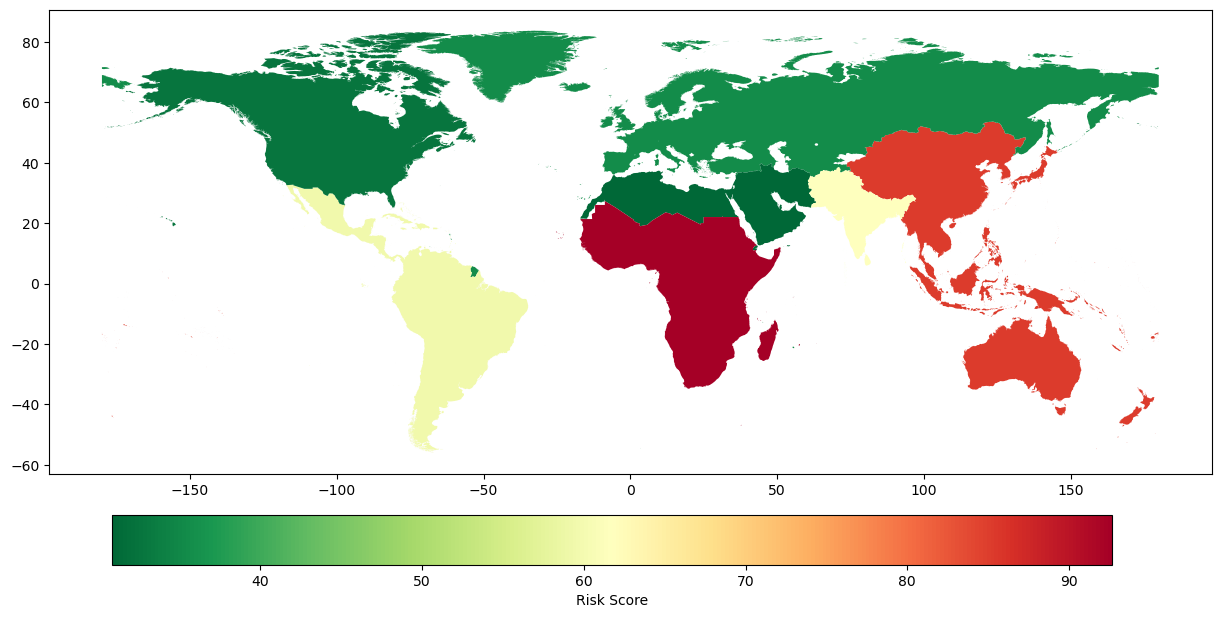

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

cbar = geo_df_reg.plot(column='risk_score', ax=ax, cmap='RdYlGn_r', legend=True,
            legend_kwds={'label': "Risk Score",
                         'orientation': "horizontal"})

cbar_ax = ax.get_figure().get_axes()[1]  
cbar_ax.set_position([0, 0.25, 1, 0.05])  

plt.show()